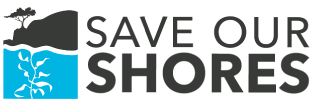

# Visualizations of Save Our Shores Cleanup Data 2013-2022

[Save Our Shores](https://saveourshores.org) (SOS) is a non-profit dedicated to ocean conservation in the Monterey Bay through education, advocacy, and beach cleanups. SOS organize many cleanup events every year, and they also coordinate over 60 cleanup sites around the Monterey Bay Marine National Sanctuary for the Annual Coastal Cleanup Day in September every year. For each event, data such as location, number of volunteers, duration, weight of trash and recycling, and types of items cleaned up are registered, and data has been collected since 2013.

This creates a rich data set that can e.g. be used to help drive policy changes around single use plastic. NOAA used the SOS data, along with other data sets, in their recent report ["Marine debris on the shoreline of Monterey Bay National Marine Sanctuary: An assessment of behaviors contributing to marine debris, categories & composition, spatial distribution, and predictor variables"](https://marinedebris.noaa.gov/other-reports/marine-debris-shoreline-monterey-bay-national-marine-sanctuary-assessment-behaviors), where they analyzed what types of trash are most prevalent, what activities they stem from, as well as exploring predictors of marine debris and suggesting recommendations.

A current focus for SOS is reducing cigarette butt waste, which is prevalent and negatively impacts our ecosystems. [Cigarette butts are made of single use plastic and don't help protect smokers from negative effects, which raises the question why they are tolerated](https://www.theguardian.com/environment/2022/aug/18/cigarette-butts-how-the-no-1-most-littered-objects-are-choking-our-coasts).

The SOS data has been stored in 1-2 xslx files for each year, with a wide variety of item names, types and site names. Code for data cleanup and plots can be found [on GitHub](https://github.com/jennyfolkesson/cleanupShores).

When possible, item categories have a similar stucture to those in NOAA's Monterey Bay National Marine Sanctuary Marine Debris report. There are some open questions, such as if items should be grouped by material or type, and what to do when the material is unknown. The code for categorizing items can be seen in the GitHub link above.

This document will be updated with more graphs as the data is further explored.

In [1]:
import circlify
import glob
import numpy as np
import os
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from pprint import pprint
import tabulate

import cleanup as cleanup 
import graphs as graphs

import plotly.io as pio
from plotly.offline import init_notebook_mode

pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=True)

Read all file and combines them into one if file isn't already saved

In [2]:
data_dir = '/Users/jenny.folkesson/Data/SOS Cleanup Data 2013-2022'
existing_file = glob.glob(os.path.join(data_dir, 'merged_sos_data.csv'))
if len(existing_file) == 1:
    sos_data = pd.read_csv(existing_file[0])
    sos_data['Date'] = pd.to_datetime(sos_data['Date'], errors='coerce')
else:
    sos_data = cleanup.merge_data(data_dir)
    sos_data.to_csv(os.path.join(data_dir, "merged_sos_data.csv"), index=False)

Below you can see the structure of the combined 2013-2022 data set. All the columns and the first five rows are on display.

In [3]:
sos_data.head()

,Date,Cleanup Site,Data Collection,Duration (Hrs),Adult Volunteers,Youth Volunteers,Trash (lbs),Recycling (lbs),County/City,Type Of Cleanup,...,Utensils,Wood Pieces,6-Pack Holders,Other,Nails,Cleaned Size (Sq Miles),Aluminum Foil,Bikes,Car Parts,Footwear
0,2013-01-12,Del Monte Beach,NaN,2.0,35.0,NaN,119.0,28.0,Monterey/Monterey,NaN,...,NaN,24.0,1.0,23.0,6.0,0.0,16.0,2.0,0.0,1.0
1,2013-01-12,Manresa State Beach,NaN,2.0,24.0,NaN,20.0,11.0,Watsonville/Santa Cruz County,NaN,...,NaN,1.0,135.0,11.0,33.0,2.0,109.0,0.0,0.0,59.0
2,2013-01-18,New Brighton State Beach,NaN,2.0,32.0,NaN,5.0,0.0,Santa Cruz/Santa Cruz,NaN,...,NaN,0.0,0.0,2.0,0.0,1.0,6.0,0.0,2.0,0.0
3,2013-01-18,Seabright State Beach,NaN,2.0,40.0,NaN,40.0,20.0,Santa Cruz/Santa Cruz,NaN,...,NaN,2.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0,3.0
4,2013-01-19,Seacliff State Beach,NaN,3.0,51.0,NaN,33.0,5.0,Aptos/Santa Cruz,NaN,...,NaN,8.0,0.0,9.0,2.0,2.0,35.0,0.0,0.0,4.0


There's also a saved config file that describe the column names of the sos_data in further detail. For each column name, the following characteristics are listed:
* potential sources from individual years
* data type (datetime, str, int, float)
* required (boolean)
* material (plastic, wood, glass, metal, mixed). NA for non items
* activity (Various, Eating/Drinking, Dumping/Disaster, 'Smoking', 'Hygiene')

In [4]:
col_config = pd.read_csv(os.path.join(data_dir, 'sos_column_info.csv'))
# find column names that do not correspond to items (material is nan)
nonitem_cols = list(col_config.loc[col_config['material'].isnull()]['name'])
col_config.head()

,name,sources,type,required,material,activity
0,Date,"['Date', 'Date Of Cleanup Event/Fecha', 'Clean...",datetime,True,NaN,NaN
1,Cleanup Site,"['Cleanup Site', 'Cleanup Site/Sitio De Limpie...",str,True,NaN,NaN
2,Cleaned Size (Sq Miles),"['Cleaned Size (Sq Miles)', 'Estimated Size Of...",int,False,NaN,NaN
3,Data Collection,"['Data Collection', 'Data Collection Method']",str,False,NaN,NaN
4,Duration (Hrs),"['Duration (Hrs)', 'Total Cleanup Duration (Hr...",int,True,NaN,NaN


## Number of Items Collected in 2023 Color Coded by Material

This circle packing graph shows the total amount of items of the given categories that have been cleaned up by Save Our Shores from in 2023. The circle sizes correspond to the number of items. When circles are too small to display the text within them, the text has been removed, and you can instead hover over the circle to see the item category and number.
The circles are color coded based on their material, with the categories Mixed, Wood, Glass, Metal and Plastic.

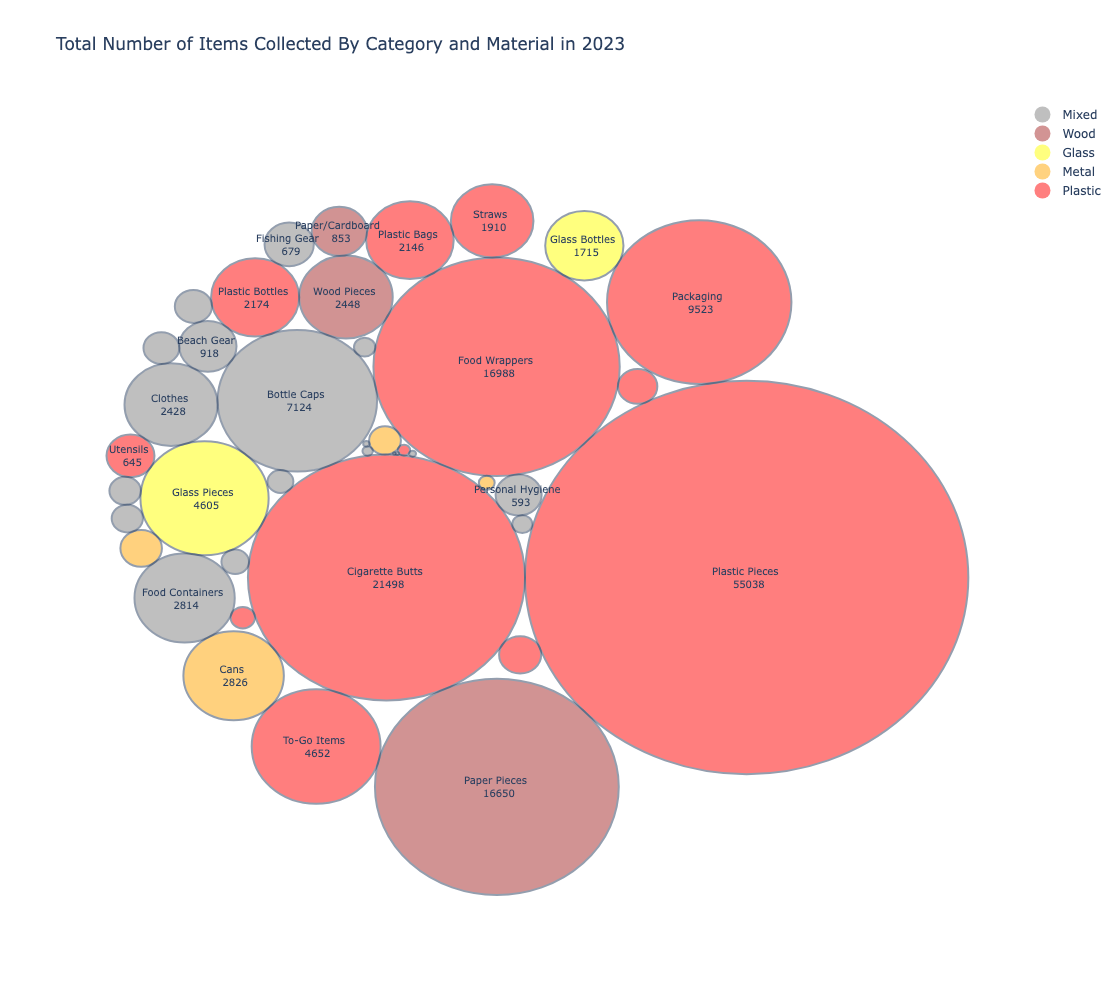

In [5]:
sos23 = sos_data[sos_data['Date'].dt.year == 2023]
fig = graphs.circle_packing_graph(sos23, col_config, plot_colors=None)
fig.show()

The above graph is a circle packing graph which shows the total number of items cleaned up by Save Our Shores 2013-2023, binned into the most common categories and color coded by material. The size of the circle is proportional to the number of items cleaned up. In circles too small to fit the item name and quanitity inside, you can hover over the center of the circle to find that information.

As you can see, plastic (in red) is by far the most common material of the marine debris cleaned up by SOS. Mixed material items (gray) like food containers, bottle caps and personal hygiene most likely contain a fair amount of plastic as well.

# Longitudinal Evaluation of Cleanup Items

Here we'll look at the number of items cleaned up by year from 2013-2023. First, let's just look at bar plots of items collected over the years and number of volunteers over the years.
In order to do that, we'll need to group the data by year. We'll also add a column for total number of volunteers, which was defined at number of adults * 0.5 * number of youths. Finally we'll add a column for total number of items, which is the sum of all the items per event.

In [6]:
# Add Total Volunteers and Total Items
col_config.loc[len(col_config.index)] = ['Total Volunteers', ['Adult + 0.5*Youth'], 'float', False, np.NaN, np.NaN]
col_config.loc[len(col_config.index)] = ['Total Items', ['Sum of items per event'], 'int', False, np.NaN, np.NaN]

sos_data['Total Volunteers'] = sos_data['Adult Volunteers'].fillna(0) + 0.5 * sos_data['Youth Volunteers'].fillna(0)
items = sos_data.copy()
items.drop(nonitem_cols, axis=1, inplace=True)
sos_data['Total Items'] = items.sum(axis=1, numeric_only=True)
# Group by year
annual_data = cleanup.group_by_year(sos_data, col_config)
# Sort items by sum in descending order so it's easier to decipher variables
s = annual_data.sum()
s = s.sort_values(ascending=False)
annual_data = annual_data[s.index]

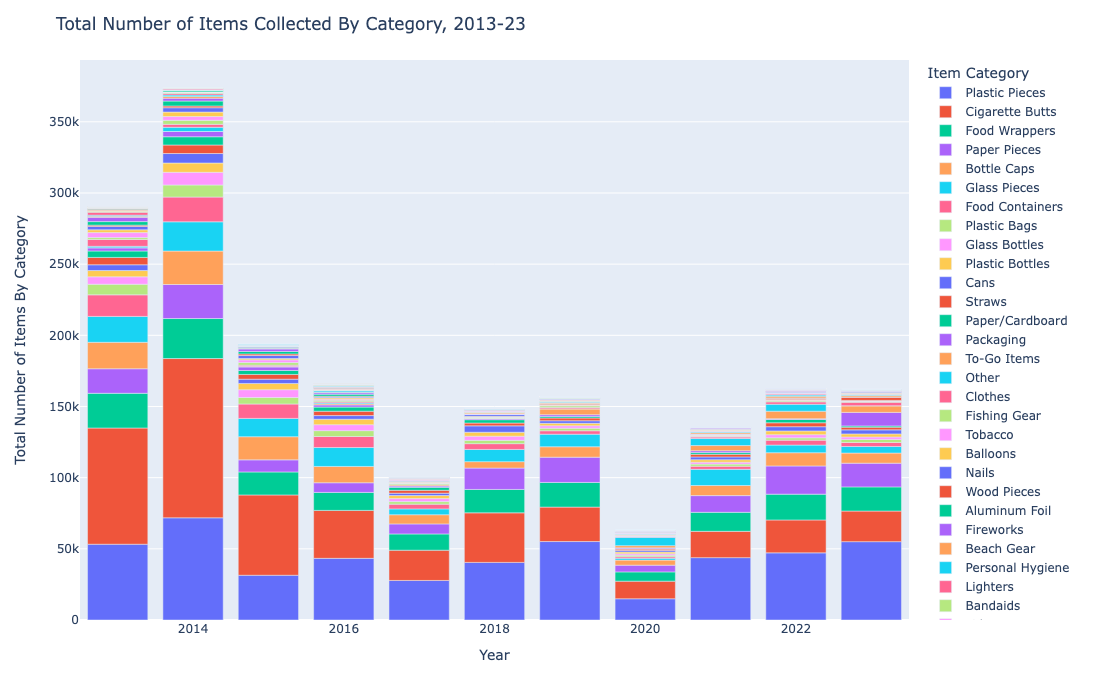

In [7]:
# Bar plot of items per year
item_cols = list(col_config.loc[col_config['material'].notnull()]['name'])
annual_items = annual_data[annual_data.columns.intersection(item_cols)]
fig = px.bar(annual_items, x=annual_items.index, y=annual_items.columns)
fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    title="Total Number of Items Collected By Category, 2013-23",
    yaxis_title='Total Number of Items By Category',
    xaxis_title='Year',
    legend_title='Item Category',
)
fig.show()

The bar graph above shows the number of items cleaned up in the years 2013-2023 by category. You can click on the Item Category squares to the right to exclude/include categories in the graph.

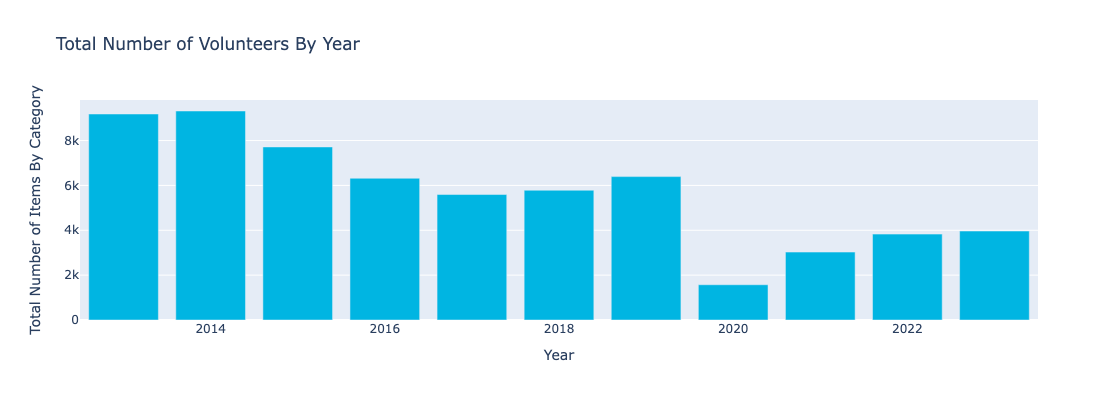

In [8]:
fig = px.bar(annual_data, x=annual_data.index, y='Total Volunteers', title="Total Number of Volunteers By Year")
fig.update_layout(
    autosize=False,
    width=850,
    height=400,
    yaxis_title='Total Number of Items By Category',
    xaxis_title='Year',
)
fig.update_traces(marker_color=graphs.SOS_BLUE)
fig.show()

The bar plot looks pretty busy, and it's hard to compare sizes of different colors when they're stacked on top of each other. So let's try lines instead. But first, let's plot the number of items as a function of the number of volunteers, since it looks like they might be correlated. It makes sense that the more people are doing cleanup, the more things get cleaned up. We could multiply the number of hours of cleanup with the number of volunteers, but there seems to be some outliers in the Duration (hrs) data, so we'll skip that for now.
Plotted below are the number of items vs number of volunteers, each summarized over a one year period.

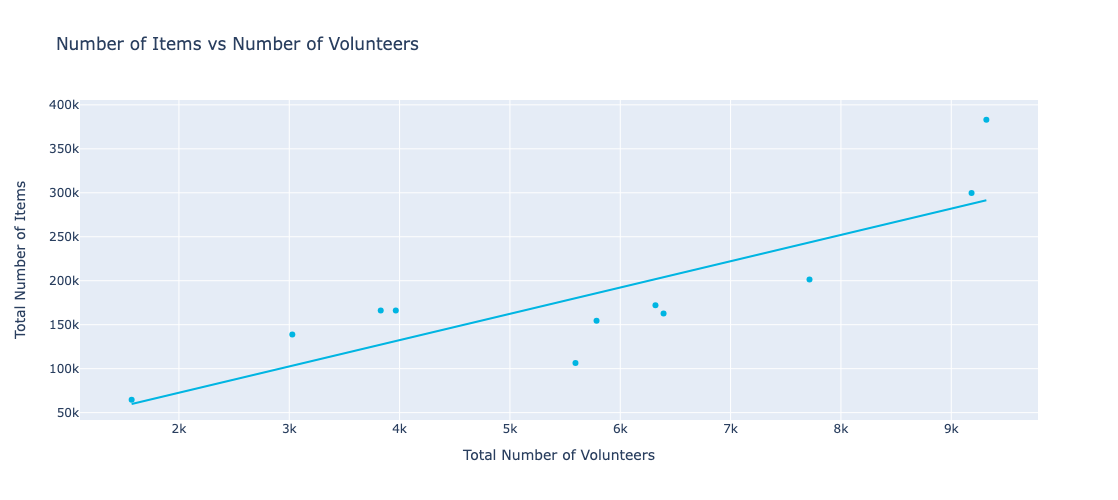

In [9]:
fig.data = []
fig = px.scatter(annual_data, 
                 x='Total Volunteers', 
                 y='Total Items', 
                 trendline="ols",
                 title="Number of Items vs Number of Volunteers",
                )
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    yaxis_title='Total Number of Items',
    xaxis_title='Total Number of Volunteers',
)
fig.update_traces(marker_color=graphs.SOS_BLUE)
fig.show()

In [10]:
# Get correlation stats
results = px.get_trendline_results(fig)

stats = [["", ""],
         ["R Squared", ""],
         ["p-value", ""],
         ["f(x)", ""]]

for idx in range(1):
    stats[1][idx + 1] = "{:.5f}".format(results.px_fit_results[idx].rsquared)
    stats[2][idx + 1] = "{}".format(results.px_fit_results[idx].pvalues[1])
    params = results.px_fit_results[idx].params
    stats[3][idx + 1] = "{:.1f}x + {:.1f}".format(params[1], params[0])

table = tabulate.tabulate(stats, tablefmt='html')
table

,
R Squared,0.70037
p-value,0.0013153365060701223
f(x),29.9x + 12849.1


There's a significant correlation between number of volunteers and number of items collected for each year, which suggests that the number of items collected in a year might depend on the number of volunteers doing beach cleanups that year. 
The fewer debris items collected in 2020 may have been a result of fewer people being out during the pandemic, and not necessarily due to less littering. Now that we know that there's a correlation between number of items and number of volunteers, let's plot items/volunteer over time.

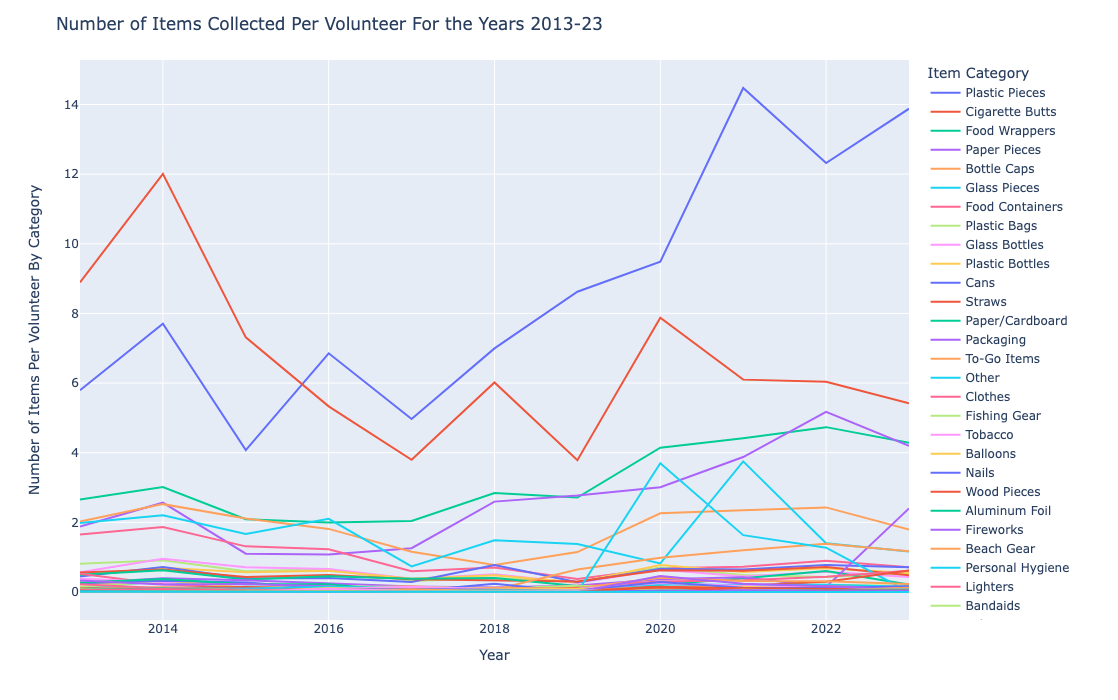

In [11]:
annual_volunteer = annual_data.copy()

item_cols = list(col_config.loc[col_config['material'].notnull()]['name'])
for item in list(item_cols):
    annual_volunteer[item] = annual_volunteer[item] / annual_volunteer['Total Volunteers']
annual_volunteer = annual_volunteer[annual_volunteer.columns.intersection(item_cols)]

fig = px.line(annual_volunteer, x=annual_volunteer.index, y=annual_volunteer.columns)
fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    title="Number of Items Collected Per Volunteer For the Years 2013-23",
    yaxis_title='Number of Items Per Volunteer By Category',
    xaxis_title='Year',
    legend_title='Item Category',
)
fig.show()

After division with number of volunteers, it seems there might be a slight decreasing trend for cigarette butts from 2020 onwards. Unfortunately there seems to be an increasing number of plastic pieces on our shores.

# Explore the Data by Cleanup Site

In the last section we looked at total number of items cleaned up over the years by Save Our Shores. Now we'll look at number of volunteers and number of items cleaned up by site.

There may be some overlap of site names as there were multiple names and spellings for what appeared to be similar sites. Some sites were located by lon, lat coordinates instead of site names, and those are not yet included here.
The code where site names are consolidated is here: https://github.com/jennyfolkesson/cleanupShores/blob/main/site_categories.yml

In [12]:
sos_sites = sos_data.copy()
sos_sites['Cleanup Site'].replace([0, 1], np.NaN, inplace=True)
sos_sites.dropna(subset=['Cleanup Site', 'Date'], inplace=True)
nonnumeric_cols = list(
    col_config.loc[~col_config['type'].isin(['int', 'float'])]['name'],
)
nonnumeric_cols.remove('Cleanup Site')
sos_sites.drop(nonnumeric_cols, axis=1, inplace=True)

sos_sites = sos_sites.groupby('Cleanup Site').sum()
sos_sites = sos_sites.reset_index()

# Select top 25 sites by number of volunteers
sos_volunteers = sos_sites.copy()
sos_volunteers.sort_values('Total Volunteers', ascending=False, inplace=True)
sos_volunteers = sos_volunteers.head(25)

Plot number of volunteers by cleanup site.

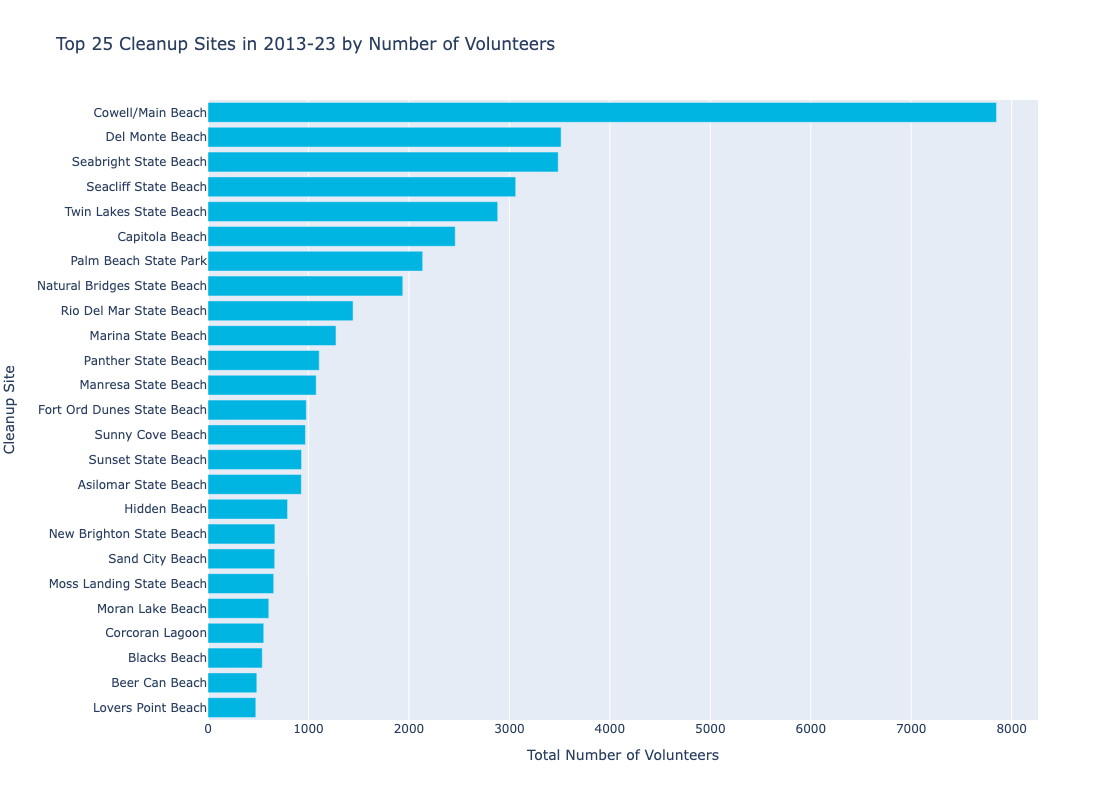

In [13]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=sos_volunteers['Cleanup Site'],
    x=sos_volunteers['Adult Volunteers'],
    orientation='h',
    name='Total Cleanup Volunteers',
    marker=dict(color=graphs.SOS_BLUE),
))
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    title="Top 25 Cleanup Sites in 2013-23 by Number of Volunteers",
    yaxis_title='Cleanup Site',
    xaxis_title='Total Number of Volunteers',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

This figure shows the total number of volunteers that have been involved in a cleanup event 2013-2022 per cleanup site. Youth volunteers, when reported, are counted as half an adult volunteer in line with the NOAA Marine Debris Report.
Cleanup sites with less than a total of 100 volunteers are not displayed.

In [14]:
# Select top 25 sites with most items cleaned up
sos_sites.sort_values('Total Items', ascending=False, inplace=True)
sos_sites = sos_sites.head(25)

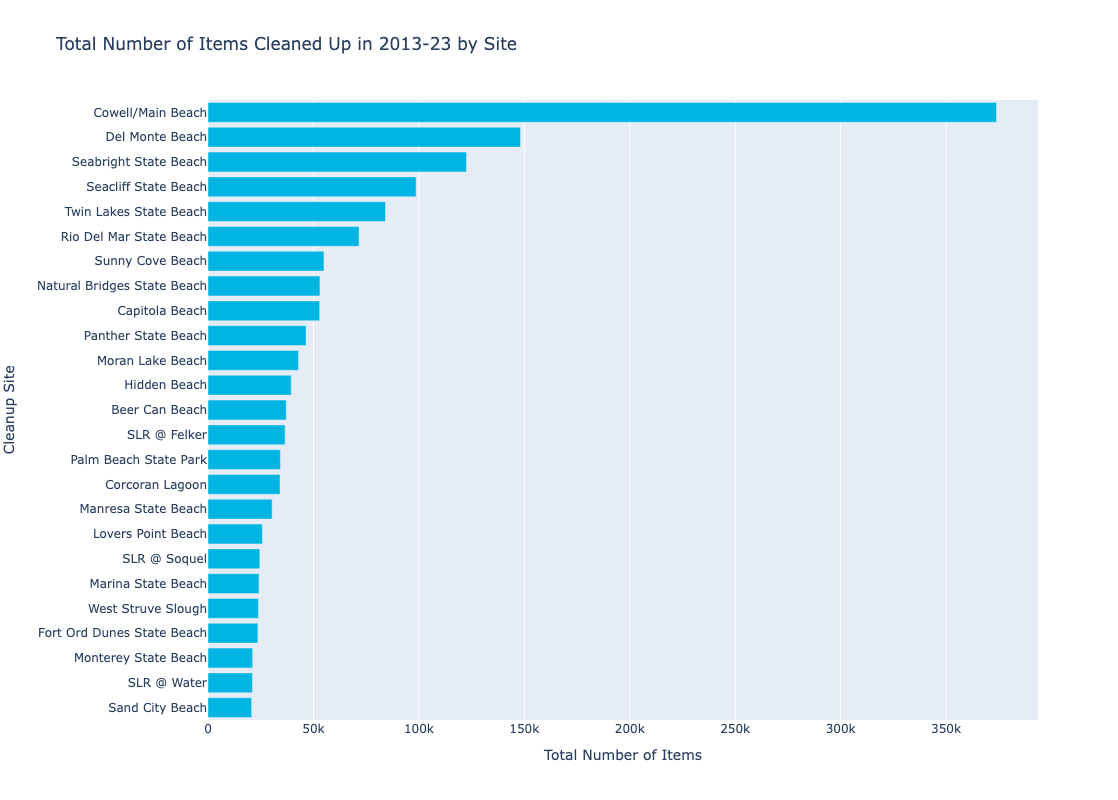

In [15]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=sos_sites['Cleanup Site'],
    x=sos_sites['Total Items'],
    orientation='h',
    name='Total Number of Items Cleaned Up',
    marker=dict(color=graphs.SOS_BLUE),
))
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    title="Total Number of Items Cleaned Up in 2013-23 by Site",
    yaxis_title='Cleanup Site',
    xaxis_title='Total Number of Items',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

Total number of items cleaned up from 2013-2022 by cleanup site. Sites with less than 5000 items are not displayed.

## Number of Cigarette Butts by Location in 2023

TODO: Add more coordinates to plot more sites. Update names.

In [16]:
sos23 = sos_data[sos_data['Date'].dt.year == 2023]
sos23 = sos23[['Cleanup Site', 'County/City', 'Cigarette Butts']]
sos23 = sos23.groupby('Cleanup Site').sum()
sos23 = sos23.reset_index()
sos23.sort_values(by=['Cigarette Butts'], ascending=False, inplace=True)
# Load file containing coordinates for site names and join it with the cigarette butt data
coords = pd.read_csv(os.path.join(data_dir, 'cleanup_site_coordinates.csv'))
sos23 = pd.merge(sos23, coords, how='left', on="Cleanup Site")
# sos23 = cleanup.add_coords(sos23)

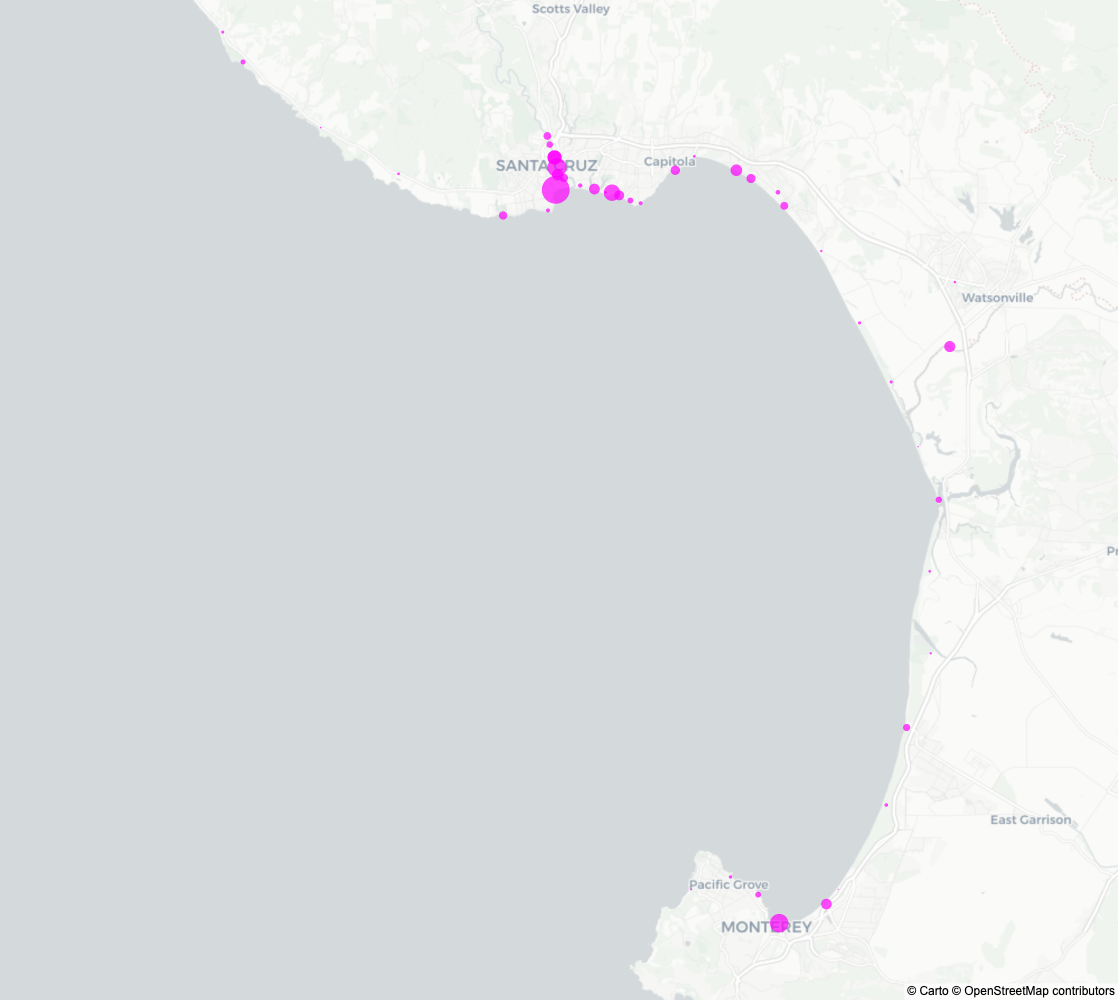

In [17]:
fig = graphs.map_graph(sos23)
fig.show()

The map above shows the sites where cigarette butts were collected in 2023. The circles (in fuchsia) are centered on the cleanup site, and the size of the circles correspond to the number of cigarette butts cleaned up from that site in 2022. You can hover over the circle to get more information, and you can zoom in and out on the map by sliding down and up with two fingers on your trackpad. SLR stands for San Lorenzo River.

This plot is limited to sites with known coordinates, and coordinates successfully located with geopy. Cleanup sites that had coordinates provided for them are listed below.
(Note: I merged Corcoran Lagoon at 20th and 26th Ave to Corcoran Lagoon, and I merged two Del Monte Beach locations into one).

In [18]:
list(coords['Cleanup Site'])

['Ano Nuevo State Beach',
 'Asilomar State Beach',
 'Beer Can Beach',
 'Blacks Beach',
 'Bonny Doon State Beach',
 'Capitola Beach',
 'Carmel Beach',
 'Carmel Meadows/Ribera Beach',
 'Carmel River State Beach',
 'Corcoran Lagoon',
 'Cowell/Main Beach',
 'Davenport Landing Beach',
 'Davenport Main Beach',
 'Del Monte Beach',
 'Fort Ord Dunes State Beach',
 'Four-Mile State Beach',
 'Greyhound Rock Beach',
 'Hidden Beach',
 'Laguna Creek Beach',
 'Lighthouse Field State Beach',
 'Lovers Point Beach',
 'Manresa State Beach',
 'Marina State Beach',
 'Mcabee State Beach',
 "Mitchell's Cove Beach",
 'Monastery Beach',
 'Monterey State Beach',
 'Moran Lake Beach',
 'Moss Landing State Beach',
 'Natural Bridges State Beach',
 'New Brighton State Beach',
 'Pajaro River',
 'Palm Beach State Park',
 'Panther State Beach',
 'Pleasure Point Beaches',
 'Point Lobos State Natural Reserve',
 'Rio Del Mar State Beach',
 'SLR @ Felker',
 'SLR @ Felton',
 'SLR @ Felton',
 'SLR @ Laurel',
 'SLR @ Riversid

## Debris Caused by Smoking, 2013-2023

Let's look at the categories specifically related to smoking and see how they've changed over time. Since there is a correlation between number of items collected and number of volunteers, we'll look at number of items per volunteer for each year. The smoking related items in the data set are: **Cigarette Butts**, **Cigar Tips**, **E-Waste**, and **Tobacco**. The Tobacco category includes items such as packaging and wrappers. Since some data categories for some year were e.g. 'Other Tobacco (Packaging, Lighter, Etc.)' or 'Smoking, Tobacco, Vape Items (Not Butts)', this general Tobacco category may include some lighters and e-waste items.

In [19]:
annual_smoking = annual_data[['Cigarette Butts', 'Cigar Tips', 'E-Waste', 'Tobacco', 'Lighters']].copy()
for item in list(annual_smoking):
    annual_smoking[item] = annual_smoking[item] / annual_data['Total Volunteers']

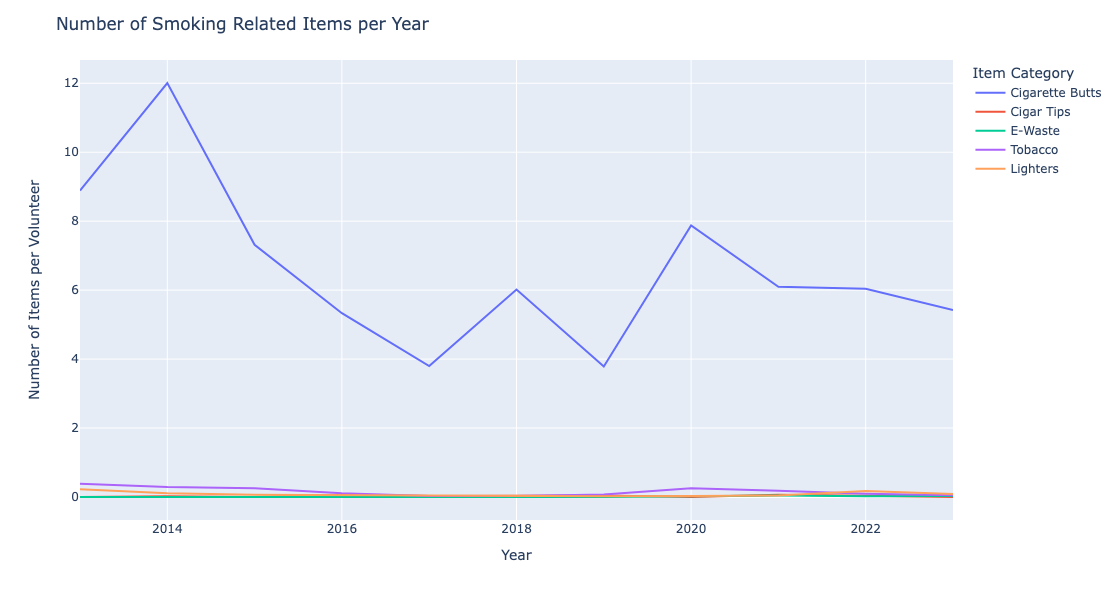

In [20]:
fig = px.line(annual_smoking, x=annual_smoking.index, y=['Cigarette Butts', 'Cigar Tips', 'E-Waste', 'Tobacco', 'Lighters'])
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title="Number of Smoking Related Items per Year",
    yaxis_title='Number of Items per Volunteer',
    xaxis_title='Year',
    legend_title='Item Category',
)
fig.show()

Cigarette butts is by far the worst polluter among smoking categories and the second worst overall after plastic pieces.

## Debris Organized by Activity 2013-2023

In NOAA's marine debris report they organized marine debris by the activities **Various**, **Eating & Drinking**, **Smoking**, **Personal Hygiene**, **Recreation**, and **Dumping and Disaster** (Figure 10 in report). Here the graph is recreated but with SOS data only, and by substituting the pie chart for a (in my opinion) a more easily interpretable bar chart. Activity names are sligthy modified to Various, Eating/Drinking, Smoking, Hygiene, Recreation and Dumping/Disaster.

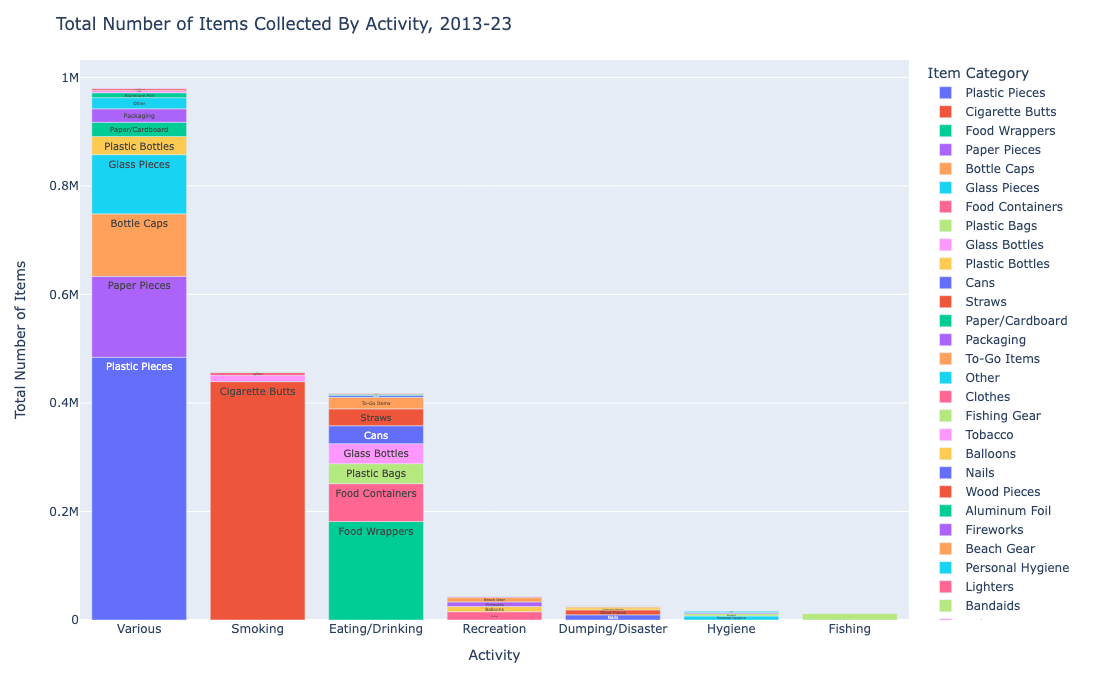

In [21]:
fig = graphs.activity_graph(sos_data, col_config)
fig.show()

The Various category contains items that could not be attributed to any of the other activites, e.g. pieces of plastic, glass and paper, and bottles and caps that could not be identified as containing beverages.

Smoking contributed to the most marine debris of all the recognizable activites (not including Various), and the vast majority of Smoking items were cigarette butts. In fact, there were more cigarette butts than all the Eating/Drinking items combined, despite the fact that only about 10% of Californians smoke, but we all eat and drink.